# importing needed libraries

In [275]:
! pip install pmdarima

In [276]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima.model import ARIMA
import pmdarima



import matplotlib.pyplot as plt

In [277]:
! pip install pmdarima


# importing dataset

In [278]:
# Open the XLS file
with open('/kaggle/input/xauusd/XAUUSD.xls', 'r') as file:
    # Read the lines of the file
    lines = file.readlines()

columns = lines[1].split(',')
columns[-1] = columns[-1].replace('\n','')

lines = lines[2:]

# making a dataframe of data

In [279]:
data = []

for line in lines:
    # Split the line by comma to get the individual values
    values = line.strip().split(',')
    # Append the values to the list as a dictionary
    data.append({'Date': values[0][:-4], 'Open': values[1], 
                 'High': float(values[2]), 'Low': float(values[3]), 'Close': float(values[4]), 
                 'Change(Pips)': int(values[5]), 'Change(%)': float(values[6])})

# Create the pandas dataframe from the list of dictionaries
df = pd.DataFrame(data)

In [280]:
df

,Date,Open,High,Low,Close,Change(Pips),Change(%)
0,7/4/2023,1921.07,1930.22,1920.34,1929.65,858,0.44
1,7/3/2023,1917.7,1930.50,1910.11,1921.17,347,0.18
2,7/2/2023,1920.3,1920.30,1917.50,1917.70,-260,-0.14
3,6/30/2023,1908.71,1922.61,1900.57,1919.20,1049,0.55
4,6/29/2023,1909.47,1913.00,1893.16,1908.76,-71,-0.04
...,...,...,...,...,...,...,...
617,7/8/2021,1803.29,1818.00,1793.90,1803.75,46,0.03
618,7/7/2021,1795.28,1809.50,1793.41,1803.22,794,0.44
619,7/6/2021,1790.85,1814.89,1789.89,1795.68,483,0.27
620,7/5/2021,1786.68,1794.00,1783.80,1791.15,447,0.25


## check if there is a null value

In [281]:
print(df.isna().sum())

Date            0
Open            0
High            0
Low             0
Close           0
Change(Pips)    0
Change(%)       0
dtype: int64


## creating a column called 'Value' to work with it 

In [282]:
df["Open"] = pd.to_numeric(df["Open"], errors='coerce')
df["Close"] = pd.to_numeric(df["Close"], errors='coerce')

df["Value"] = (df["Open"] + df["Close"]) / 2

# # Save the updated dataset to a new CSV file
# df.to_csv("gold_prices_with_overall_price.csv", index=False)

In [283]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Change(Pips)', 'Change(%)',
       'Value'],
      dtype='object')

### make our needed dataframe

In [284]:
new_df = df.loc[:, ['Date', 'Value']]
# new_df['Date'] = pd.to_datetime(new_df['Date'])

# Print the new DataFrame
new_df['Date']

0       7/4/2023 
1       7/3/2023 
2       7/2/2023 
3      6/30/2023 
4      6/29/2023 
          ...    
617     7/8/2021 
618     7/7/2021 
619     7/6/2021 
620     7/5/2021 
621     7/4/2021 
Name: Date, Length: 622, dtype: object

<Axes: >

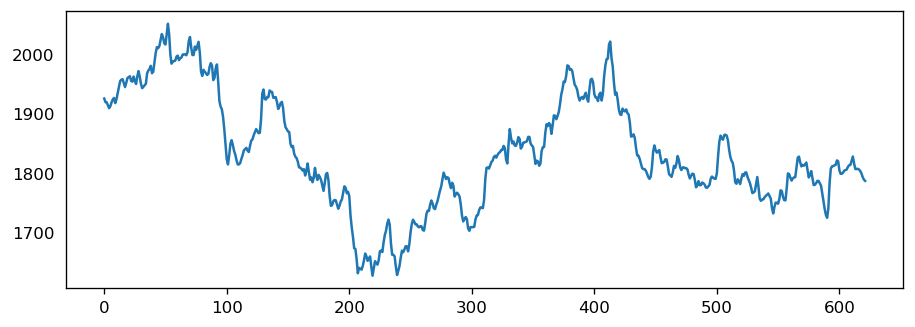

In [285]:
df.Value.plot()

In [286]:
new_df

,Date,Value
0,7/4/2023,1925.360
1,7/3/2023,1919.435
2,7/2/2023,1919.000
3,6/30/2023,1913.955
4,6/29/2023,1909.115
...,...,...
617,7/8/2021,1803.520
618,7/7/2021,1799.250
619,7/6/2021,1793.265
620,7/5/2021,1788.915


## decompose a time series into its components

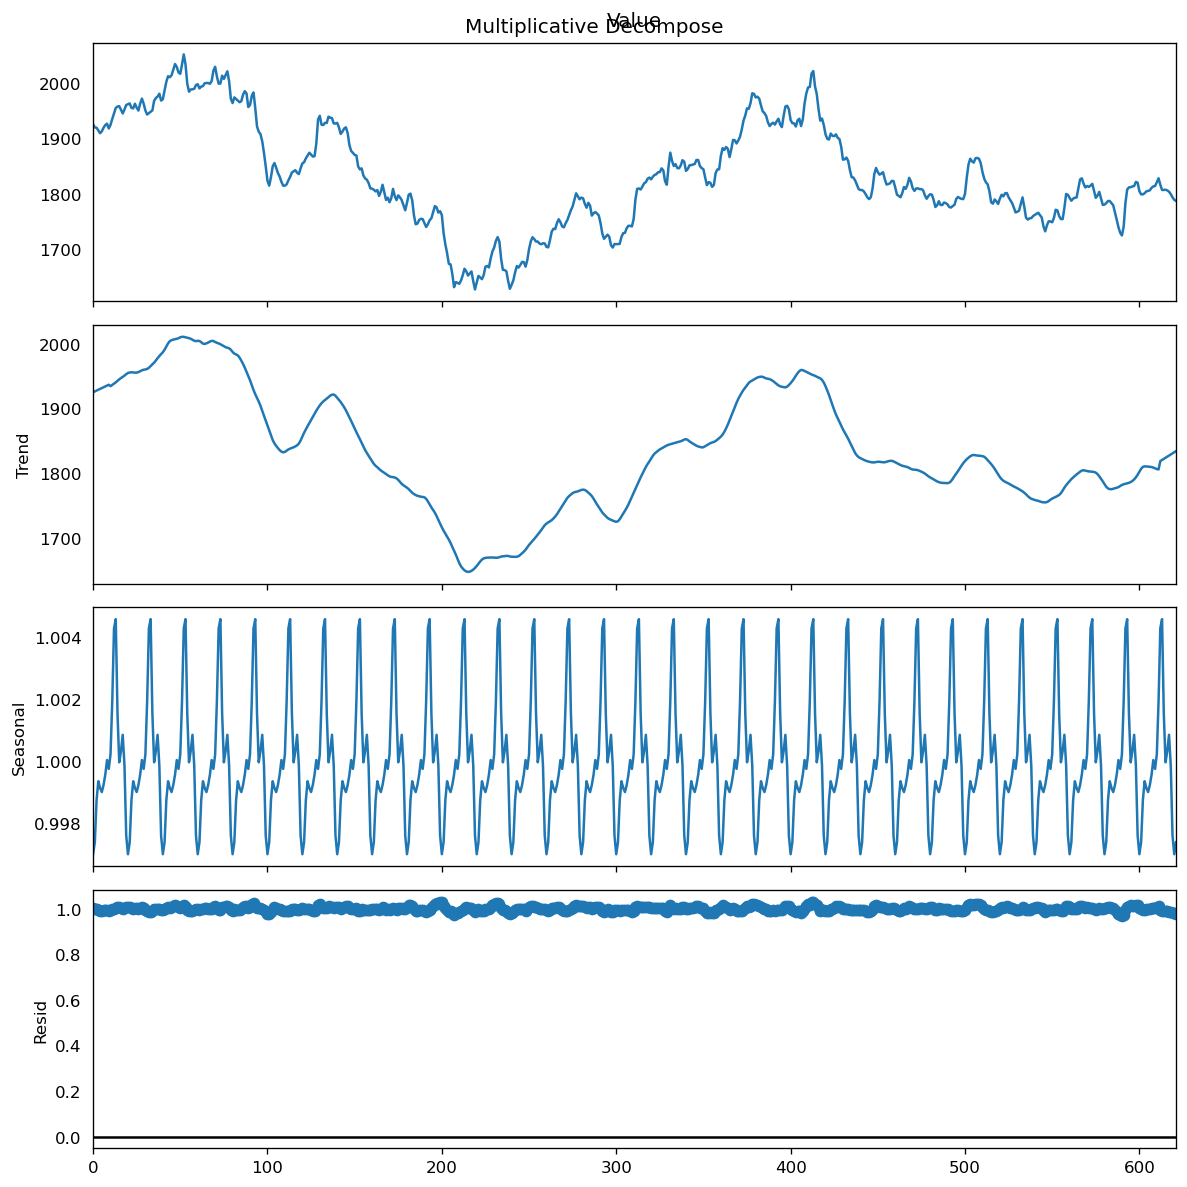

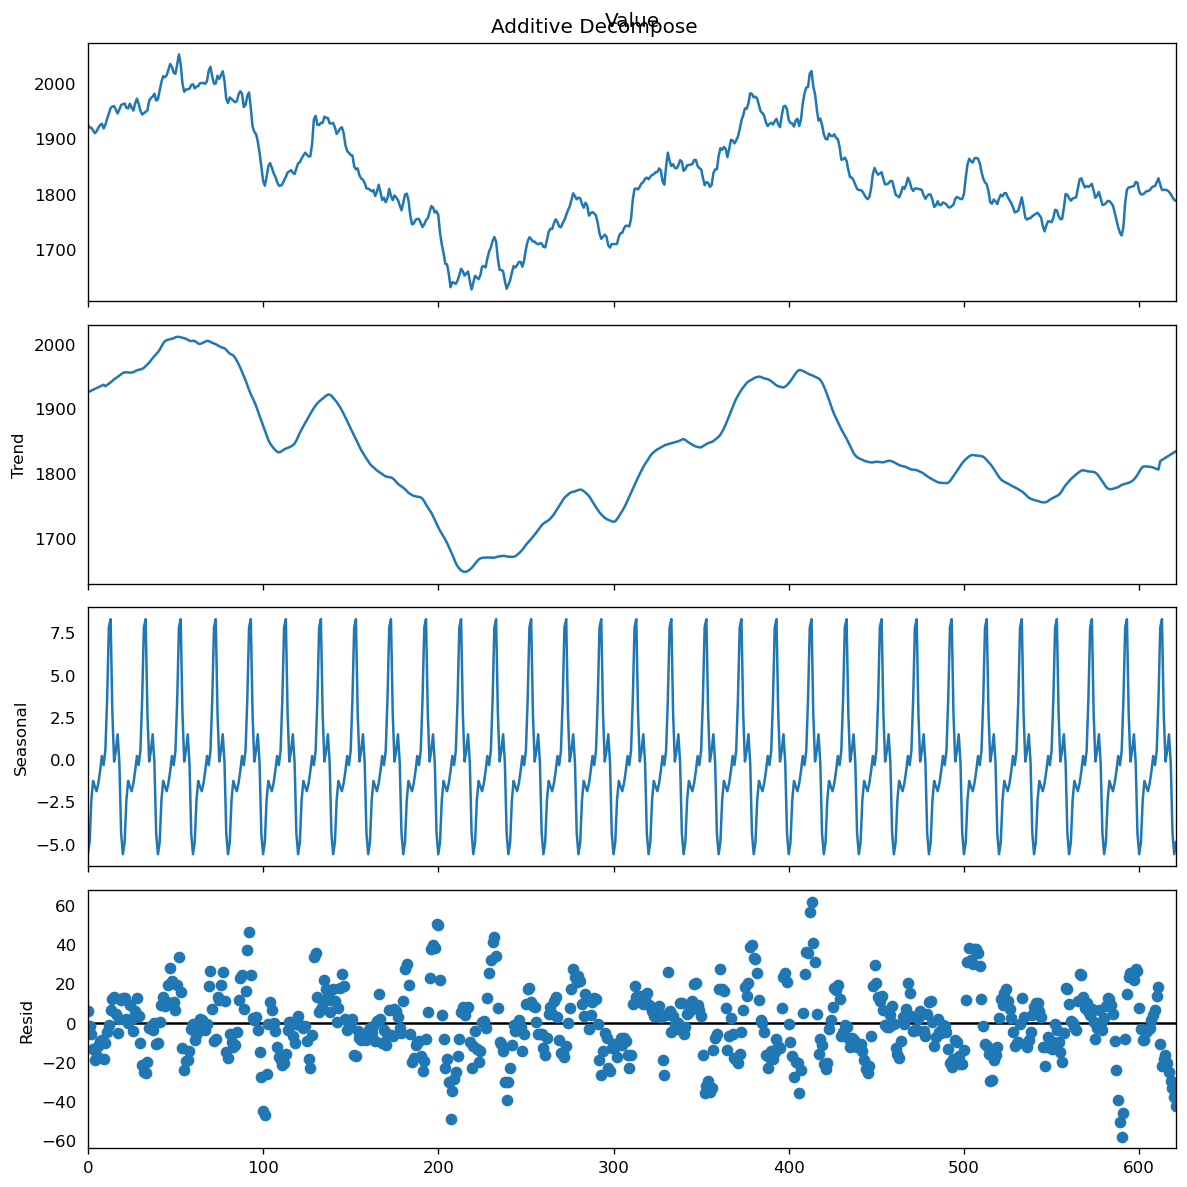

In [287]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(new_df['Value'], model='multiplicative', extrapolate_trend='freq',period=20)

# Additive Decomposition
result_add = seasonal_decompose(new_df['Value'], model='additive', extrapolate_trend='freq',period=20)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose')
result_add.plot().suptitle('Additive Decompose')
plt.show()

## testing stationarity

In [288]:
# ADF Test
result = adfuller(new_df.Value.values, autolag='AIC')

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(new_df.Value.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.9737432727060404
p-value: 0.29820307437597904
Critial Values:
   1%, -3.4410627157395908
Critial Values:
   5%, -2.8662664495424255
Critial Values:
   10%, -2.5692871001333266

KPSS Statistic: 0.700088
p-value: 0.013537
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


## deterending our timeseries

Text(0.5, 1.0, 'dataset detrended by subtracting the least squares fit')

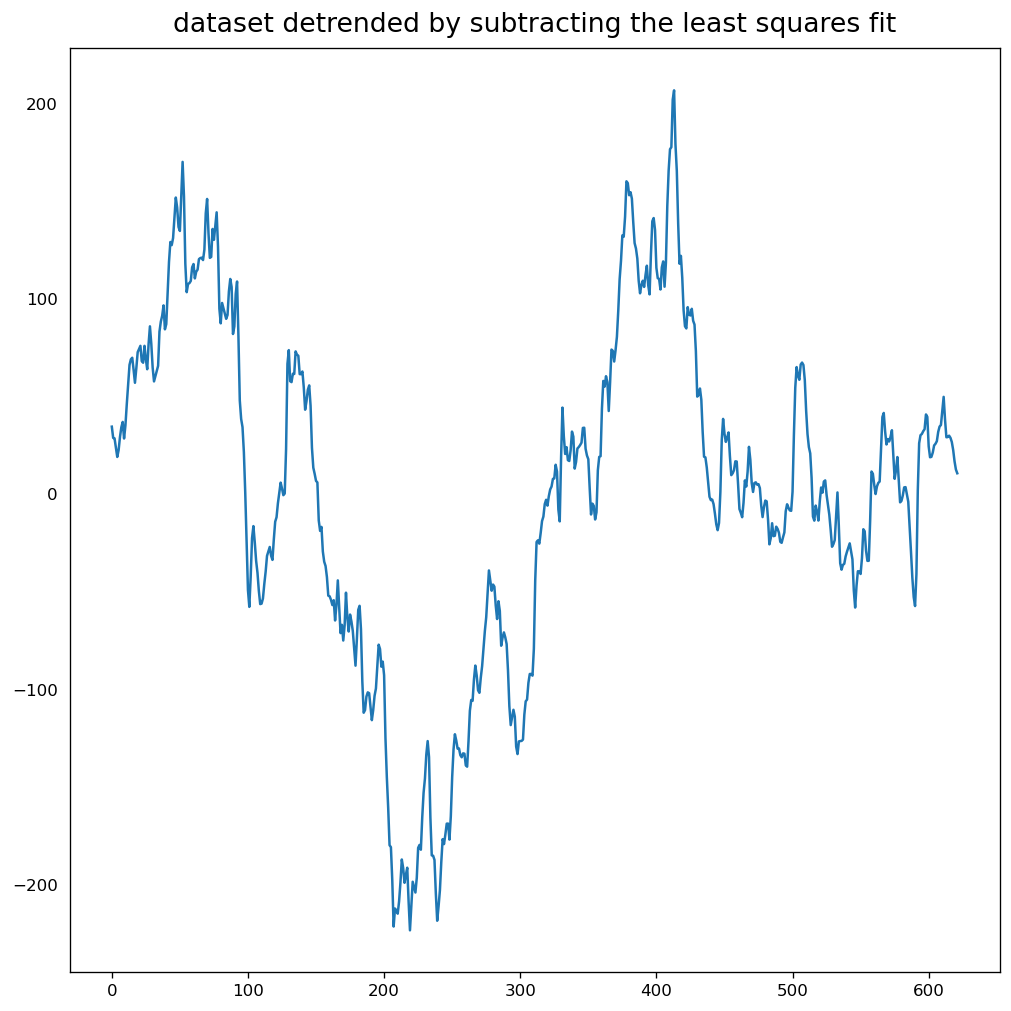

In [289]:
detrended = signal.detrend(new_df.Value.values)
plt.plot(detrended)
plt.title('dataset detrended by subtracting the least squares fit', fontsize=16)

Text(0.5, 1.0, 'Dataset detrended by subtracting the trend component')

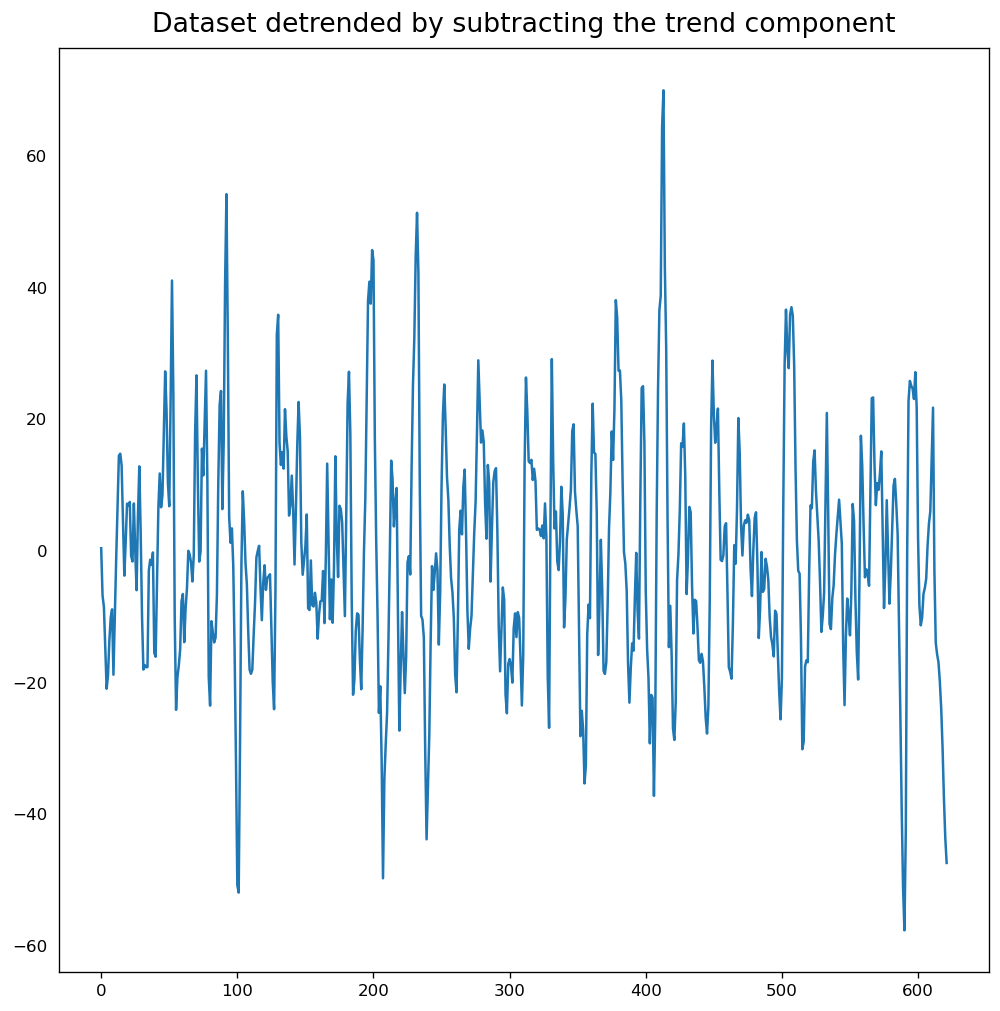

In [290]:
# Using statmodels: Subtracting the Trend Component.
detrended = new_df.Value.values - result_mul.trend
plt.plot(detrended)
plt.title('Dataset detrended by subtracting the trend component', fontsize=16)

## deseasonalizing the time series

[]

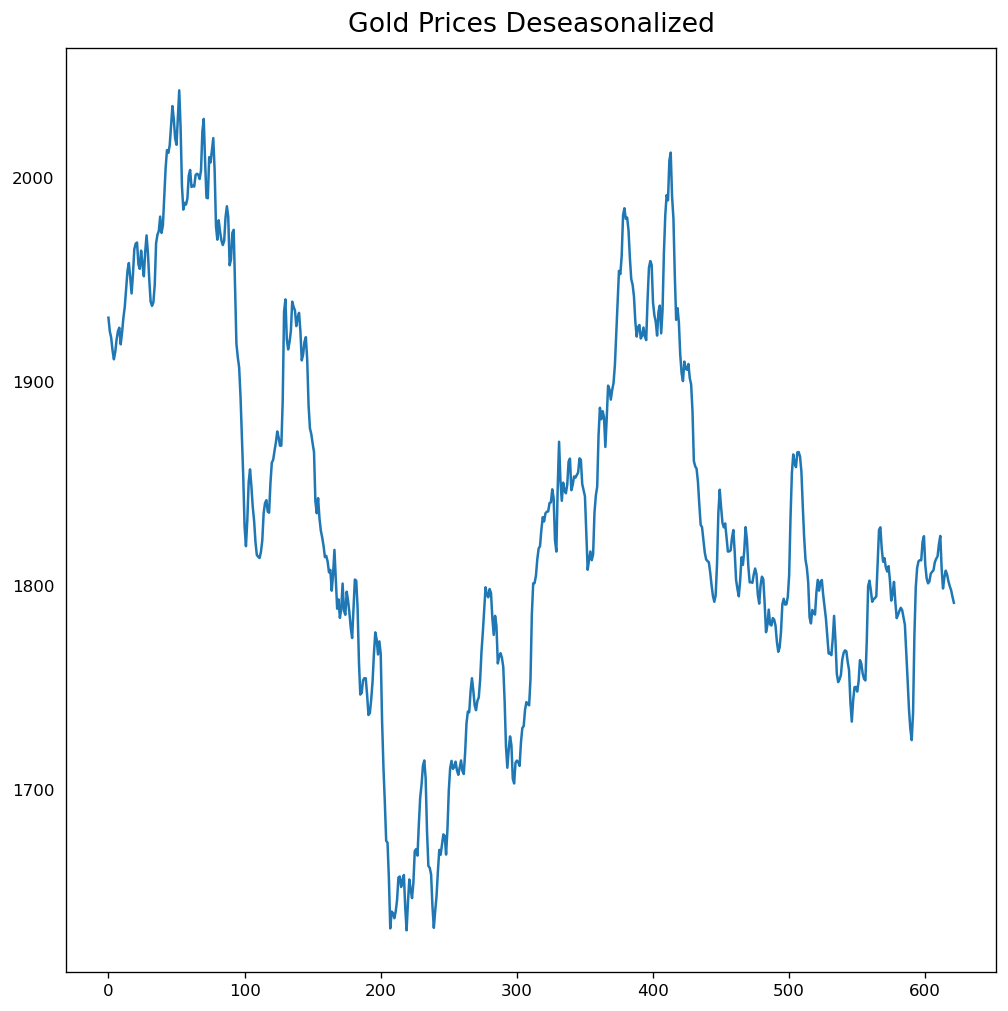

In [291]:
# Deseasonalize
deseasonalized = new_df.Value.values / result_mul.seasonal

# Plot
plt.plot(deseasonalized)
plt.title('Gold Prices Deseasonalized', fontsize=16)
plt.plot()


## autocorrelation and partial autocorrelation functions

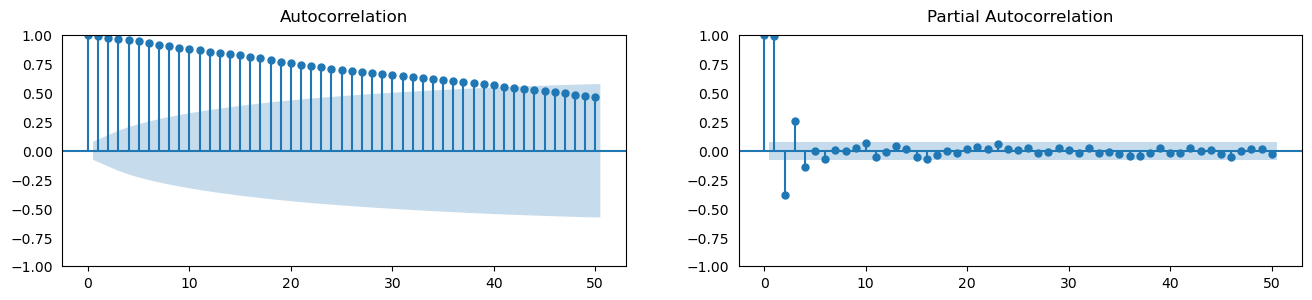

In [292]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(new_df.Value.tolist(), lags=50, ax=axes[0]);
plot_pacf(new_df.Value.tolist(), lags=50, ax=axes[1]);

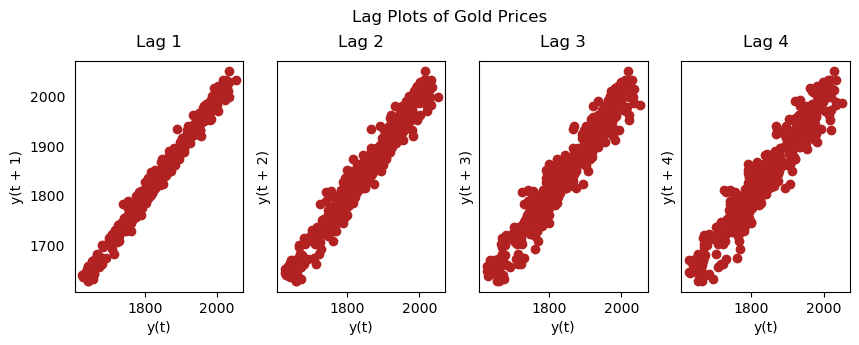

In [293]:
# Import
df = new_df

plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df.Value, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Gold Prices', y=1.05)    
plt.show()

## estimating the forecastability of our timeseries

In [294]:
df = new_df

rand_small = np.random.randint(0, 100, size=36)
rand_big = np.random.randint(0, 100, size=136)

def ApEn(U, m, r):
    """Compute Aproximate entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))

print(ApEn(df.Value, m=2, r=0.2*np.std(df.Value)))   # 0.398
print(ApEn(rand_small, m=2, r=0.2*np.std(rand_small))) # 0.129
print(ApEn(rand_big, m=2, r=0.2*np.std(rand_big)))     # 0.654

0.39890161261870327
0.12828115115295669
0.7485042599489402


In [295]:
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

print(SampEn(df.Value, m=2, r=0.2*np.std(df.Value)))    # 0.41
print(SampEn(rand_small, m=2, r=0.2*np.std(rand_small)))  # 1.79
print(SampEn(rand_big, m=2, r=0.2*np.std(rand_big)))      # 2.42

0.32187999206262125
1.6094379124341003
2.8810693652338513


## Granger Causality test

In [296]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
grangercausalitytests(df[['Value', 'Month']], maxlag=2);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9193  , p=0.3380  , df_denom=618, df_num=1
ssr based chi2 test:   chi2=0.9238  , p=0.3365  , df=1
likelihood ratio test: chi2=0.9231  , p=0.3367  , df=1
parameter F test:         F=0.9193  , p=0.3380  , df_denom=618, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7584  , p=0.1732  , df_denom=615, df_num=2
ssr based chi2 test:   chi2=3.5453  , p=0.1699  , df=2
likelihood ratio test: chi2=3.5352  , p=0.1707  , df=2
parameter F test:         F=1.7584  , p=0.1732  , df_denom=615, df_num=2


##  finding the order of differencing (d) in ARIMA model

In [297]:
result = adfuller(new_df.Value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.973743
p-value: 0.298203


/opt/conda/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


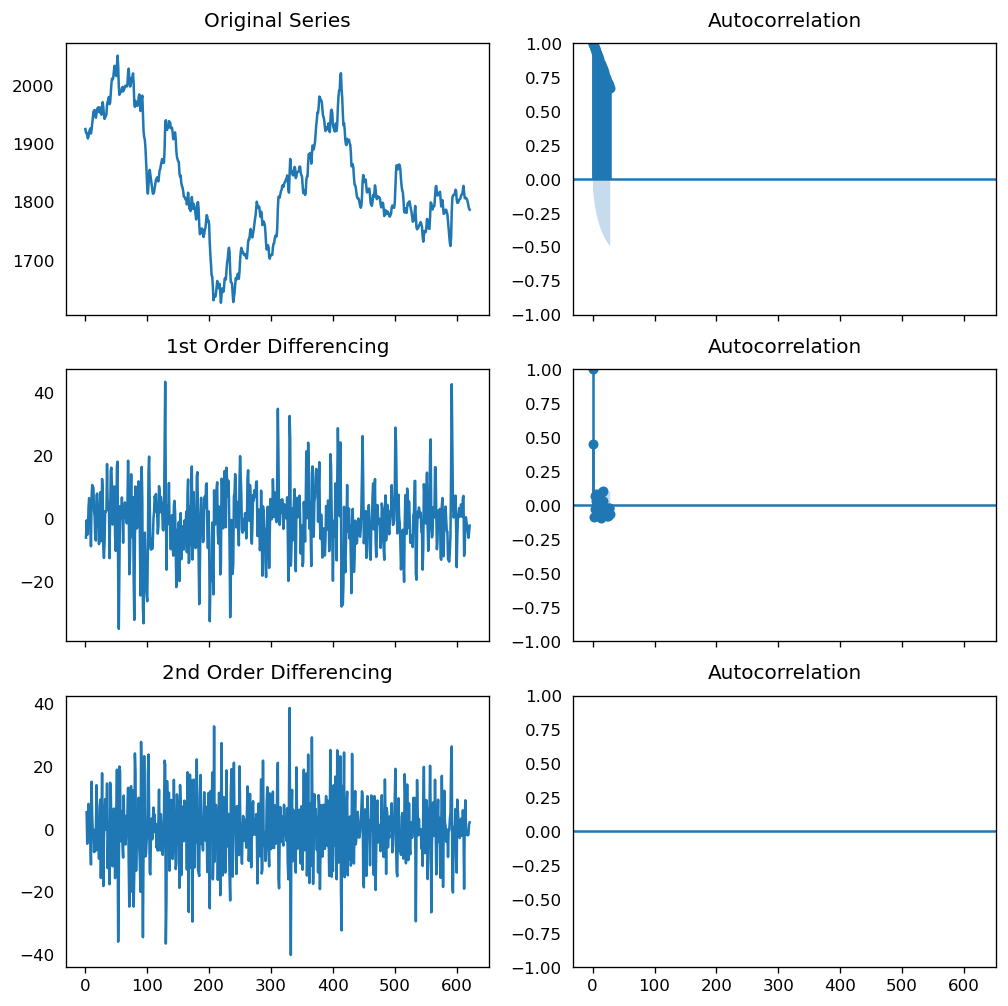

In [298]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(new_df.Value); axes[0, 0].set_title('Original Series')
plot_acf(new_df.Value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(new_df.Value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(new_df.Value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(new_df.Value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(new_df.Value.diff().diff(), ax=axes[2, 1])

plt.show()

In [299]:
y = new_df.Value

## Adf Test
ndiffs(y, test='adf')  

1

## finding the order of the AR term (p)

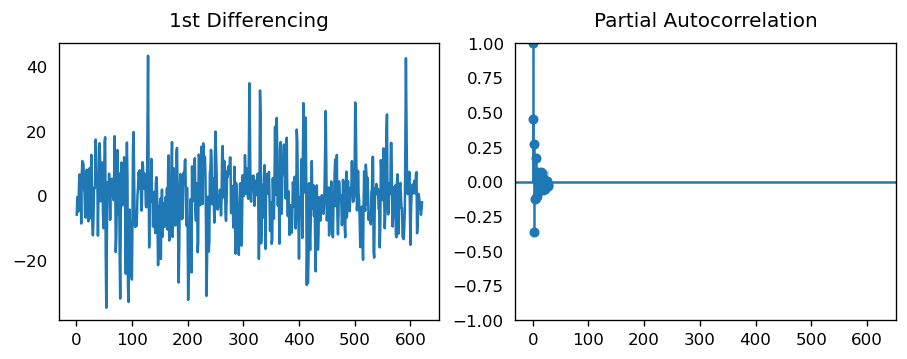

In [300]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(new_df.Value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(new_df.Value.diff().dropna(), ax=axes[1])

plt.show()

## finding the order of the MA term (q)

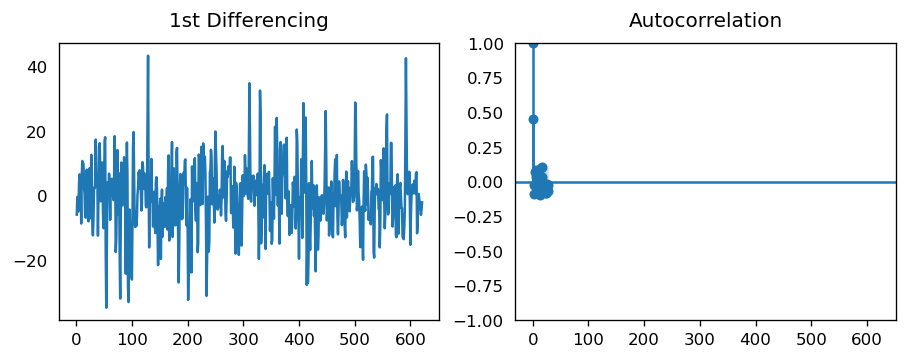

In [301]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})


fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(new_df.Value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(new_df.Value.diff().dropna(), ax=axes[1])

plt.show()

## building the ARIMA model

In [302]:
model = ARIMA(new_df.Value, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  622
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -2183.057
Date:                Wed, 12 Jul 2023   AIC                           4374.115
Time:                        06:05:26   BIC                           4391.840
Sample:                             0   HQIC                          4381.004
                                - 622                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5249      1.126      0.466      0.641      -1.682       2.732
ma.L1          0.2492      1.114      0.224      0.823      -1.935       2.433
ma.L2         -0.4344      0.873     -0.497      0.6

In [303]:
model = ARIMA(new_df.Value, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  622
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2183.186
Date:                Wed, 12 Jul 2023   AIC                           4372.371
Time:                        06:05:26   BIC                           4385.665
Sample:                             0   HQIC                          4377.538
                                - 622                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0145      0.047      0.307      0.759      -0.078       0.107
ma.L1          0.7873      0.027     29.327      0.000       0.735       0.840
sigma2        66.1339      2.959     22.350      0.0

In [304]:
# model_fit.plot_predict(dynamic=False)
# plt.show()

In [305]:
train = new_df.Value[:500]
test = new_df.Value[500:]

In [306]:
# 1,1,1 ARIMA Model
model = ARIMA(new_df.Value, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  622
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2183.186
Date:                Wed, 12 Jul 2023   AIC                           4372.371
Time:                        06:05:26   BIC                           4385.665
Sample:                             0   HQIC                          4377.538
                                - 622                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0145      0.047      0.307      0.759      -0.078       0.107
ma.L1          0.7873      0.027     29.327      0.000       0.735       0.840
sigma2        66.1339      2.959     22.350      0.0

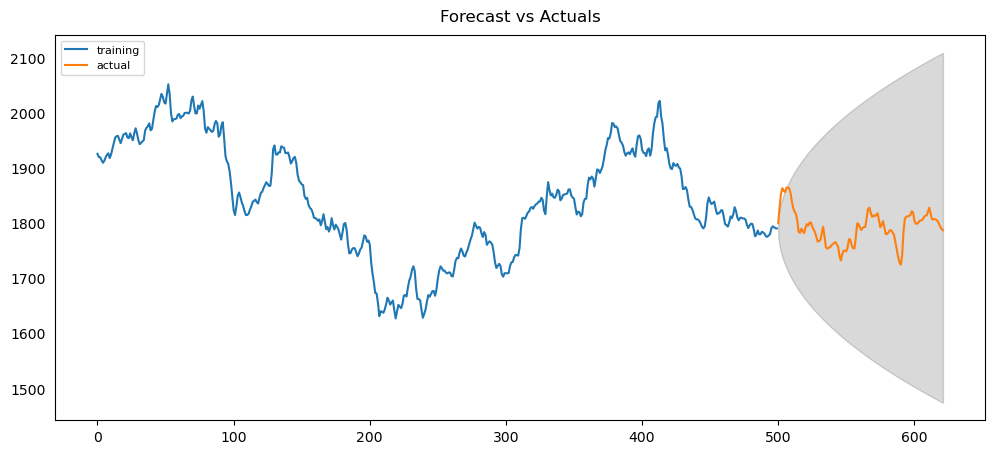

In [307]:
model = ARIMA(train, order=(1, 1, 1))

# fit ARIMA model
fitted = model.fit()

# make predictions
forecast = fitted.get_forecast(steps=len(test), dynamic=True)
fc = forecast.predicted_mean
conf = forecast.conf_int(alpha=0.05)

# convert predictions to pandas series
fc_series = pd.Series(fc, index=test.index)
conf_array = conf.to_numpy()  # convert conf DataFrame to a NumPy array
lower_series = pd.Series(conf_array[:, 0], index=test.index)
upper_series = pd.Series(conf_array[:, 1], index=test.index)

# plot results
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [308]:
import pmdarima as pm


model = pm.auto_arima(new_df.Value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4374.215, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4677.909, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4539.032, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4372.306, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4676.193, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4374.185, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4375.942, Time=0.37 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4370.466, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4372.371, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4372.340, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4537.151, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4374.115, Time=0.19 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.569 seconds
                               SARIMAX Results                                
Dep. Vari

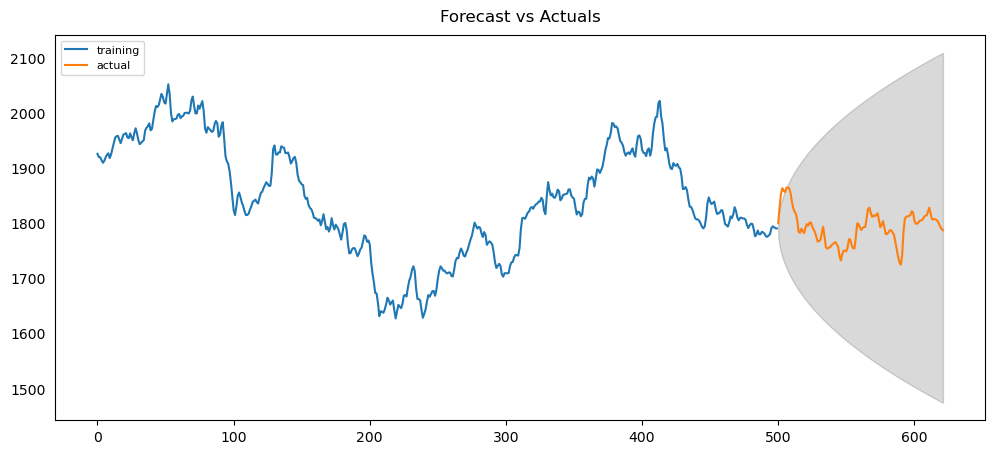

In [309]:
model = ARIMA(train, order=(1, 1, 1))

# fit ARIMA model
fitted = model.fit()

# make predictions
forecast = fitted.get_forecast(steps=len(test), dynamic=True)
fc = forecast.predicted_mean
conf = forecast.conf_int(alpha=0.05)

# convert predictions to pandas series
fc_series = pd.Series(fc, index=test.index)
conf_array = conf.to_numpy()  # convert conf DataFrame to a NumPy array
lower_series = pd.Series(conf_array[:, 0], index=test.index)
upper_series = pd.Series(conf_array[:, 1], index=test.index)

# plot results
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()